In [64]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)

In [1]:
import zipfile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Unzip the downloaded file
def unzip_data(filename):
  """
  Utility function to unzip a zipped file.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

In [35]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [36]:
def load_image(image):
    image_bgr = cv2.imread(image, cv2.IMREAD_COLOR)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb), plt.axis("off")
    plt.show()
    

In [2]:
# Setup data inputs
IMG_SIZE = (224, 224)

def create_data_loaders(train_dir, test_dir, image_size=IMG_SIZE):
  """
  Creates a training and test image BatchDataset from train_dir and test_dir.
  """
  train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                  label_mode="categorical",
                                                                  image_size=image_size)
  # Note: the test data is the same as the previous experiment, we could
  # skip creating this, but we'll leave this here to practice.
  test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                  label_mode="categorical",
                                                                  image_size=image_size)
  
  return train_data, test_data

In [3]:
# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

In [4]:
# Setup input shape and base model, freezing the base model layers
INPUT_SHAPE = (224, 224, 3)
BASE_MODEL = tf.keras.applications.EfficientNetB0(include_top=False)

def create_model(input_shape=INPUT_SHAPE, base_model=BASE_MODEL, num_classes=10):
  # Fine-tune?
  base_model.trainable = False

  # Create input layer
  inputs = layers.Input(shape=input_shape, name="input_layer")

  # Add in data augmentation Sequential model as a layer
  x = data_augmentation(inputs)

  # Give base_model inputs (after augmentation) and don't train it
  x = base_model(x, training=False)

  # Pool output features of base model
  x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

  # Put a dense layer on as the output
  outputs = layers.Dense(num_classes, activation="softmax", name="output_layer")(x)

  # Make a model with inputs and outputs
  model = keras.Model(inputs, outputs)

  # Compile the model
  model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
  
  return model

In [5]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224, scale=False):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  # Rescale the image (get all values between 0 and 1)
  if scale:
    return img/255.
  else:
    return img

In [6]:
!pip install wget

You should consider upgrading via the 'c:\users\plaba\anaconda3\python.exe -m pip install --upgrade pip' command.


In [7]:
# Get data
import zipfile
import wget

# Download data (10 class subset of Food101 - https://www.kaggle.com/dansbecker/food-101)
# Already formatted in standard image classification directory style
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

unzip_data("10_food_classes_all_data.zip")

In [8]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_all_data"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data\test'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\steak'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\sushi'.
There are 

## Model 1 (10 classes)

In [9]:
# Create BatchDataset
train_data, test_data = create_data_loaders(train_dir="10_food_classes_all_data/train/",
                                            test_dir="10_food_classes_all_data/test/")

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [10]:
# What size is our data?
train_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [11]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [12]:
# Create model
model_1 = create_model(num_classes=len(train_data.class_names))

# Fit the model
history_1_percent = model_1.fit(train_data,
                    epochs=5,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=int(0.25 * len(test_data)), # validate for less steps
                    # Track model training logs
                    callbacks=[create_tensorboard_callback("transfer_learning", "all_data_aug")])

Saving TensorBoard log files to: transfer_learning/all_data_aug/20210820-165813
Epoch 1/5
235/235 [==============================] - 496s 2s/step - loss: 1.4320 - accuracy: 0.5597 - val_loss: 0.4827 - val_accuracy: 0.8750
Epoch 2/5
235/235 [==============================] - 475s 2s/step - loss: 0.6865 - accuracy: 0.7950 - val_loss: 0.4122 - val_accuracy: 0.8668
Epoch 3/5
235/235 [==============================] - 456s 2s/step - loss: 0.6053 - accuracy: 0.8159 - val_loss: 0.3761 - val_accuracy: 0.8849
Epoch 4/5
235/235 [==============================] - 488s 2s/step - loss: 0.5469 - accuracy: 0.8337 - val_loss: 0.3760 - val_accuracy: 0.8750
Epoch 5/5
235/235 [==============================] - 512s 2s/step - loss: 0.5312 - accuracy: 0.8364 - val_loss: 0.3383 - val_accuracy: 0.8898


In [13]:
# Classes our model is trained on
class_names = train_data.class_names
class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

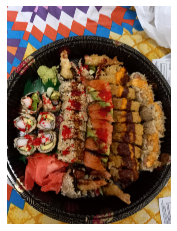

In [48]:
image = "test_sushi.jpg"
load_image(image)

In [49]:
# Preprocess image
test_img = load_and_prep_image(image)

In [50]:
# Make predictions
test_img_expanded = tf.expand_dims(test_img, axis=0) # expand image dimensions (224, 224, 3) -> (1, 224, 224, 3)
pred = model_1.predict(test_img_expanded)

In [51]:
# Check the predicted class
food_class = class_names[tf.argmax(pred[0])]
food_class

'sushi'

In [57]:
def upload_checker(food):
    flag = False
    flag = True if food in class_names else flag
    print("Image will be uploaded") if flag == True else print("Uploaded image is not a food and will not be uploaded")

In [58]:
upload_checker(food_class)

Image will be uploaded


In [59]:
# model_1.save('10_class_food_classification_model') 

INFO:tensorflow:Assets written to: 10_class_food_classification_model\assets


INFO:tensorflow:Assets written to: 10_class_food_classification_model\assets


In [19]:
new_model = tf.keras.models.load_model('10_class_food_classification_model')

In [60]:
# Preprocess image
test_img = load_and_prep_image("test_image.jfif")

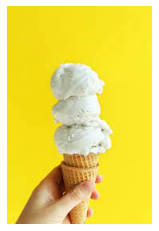

In [61]:
load_image("test_image.jfif")

In [62]:
# Make predictions
test_img_expanded = tf.expand_dims(test_img, axis=0) # expand image dimensions (224, 224, 3) -> (1, 224, 224, 3)
pred = new_model.predict(test_img_expanded)

In [63]:
# Check the predicted class
class_names[tf.argmax(pred[0])]

'ice_cream'